# Infomap

In [17]:
import ast
import collections
import json
import math
import os
import re
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from dotenv import find_dotenv, load_dotenv
from infomap import Infomap
from networkx.algorithms.cuts import conductance

* **Infomap** is a **community detection algorithm** introduced by Martin Rosvall & Carl T. Bergstrom (2008).
* Instead of optimizing modularity (like Louvain/Leiden), it uses an **information-theoretic approach**:

  * Imagine a random walker moving along the network (following edges).
  * If the walker tends to spend more time in certain parts of the graph (dense citation neighborhoods), those regions form **modules (communities)**.
  * Infomap tries to **compress the description of the walk** by grouping nodes into modules — the best compression corresponds to the best community structure.

---

**Key Features**

* **Directed & Weighted**: Works naturally with directed edges.
* **Hierarchical**: Can detect **nested subcommunities**.
* **Flow-based**: Communities correspond to **citation navigation paths**, not just density.
* **Scalable**: Works well up to millions of edges.

---

**How It Works (Conceptually)**

1. **Random Walk Simulation**

   * A random walker moves through the graph, following outgoing edges.
   * The probability of being on a node reflects its **citation centrality**.

2. **Compression via the “Map Equation”**

   * Infomap asks: *How can I describe the random walk with the fewest bits?*
   * If the walker stays inside a cluster often, you can give that cluster a short “code name” — this reduces the description length.

3. **Community Assignment**

   * The algorithm partitions nodes into communities that minimize description length.
   * Result: Communities where information flow is trapped for long periods.

---

* *“Where would a reader get ‘trapped’ if they were clicking through citations?”*
* That “trap” = a community.

---

## Dataset NQ version 0

In [14]:
df = pd.read_csv("../data/v0.0/df_nq_version0.csv")
df

,id,d_properties_document_title,d_properties_title_encode,cites_ids
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ..."
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156..."
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1..."
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,..."
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123..."
...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001..."
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452..."
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]"
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708..."


In [ ]:
# Convert stringified lists into real Python lists
df["cites_ids"] = df["cites_ids"].apply(ast.literal_eval)

# Now check types again
print(df["cites_ids"].map(type).value_counts())
print(df["cites_ids"].iloc[0])  # should be a real list of ints now

cites_ids
<class 'list'>    108071
Name: count, dtype: int64
[6352, 2622, 5393, 3079, 15650, 33906, 13375, 17089, 21278, 40756, 23630, 31751, 36732, 29709, 39868, 19801, 16597, 28821, 10527, 29686, 26683, 10124, 42686, 21384, 16399, 32515]


## Implementation

In [18]:
# Initialize Infomap instance for directed graph
im = Infomap("--directed")

# Add edges
for _, row in df.iterrows():
    src = row["id"]
    for tgt in row["cites_ids"]:
        im.add_link(src, tgt)

In [19]:
im.run()
print(f"Found {im.num_top_modules} top modules with codelength: {im.codelength}")

Found 1294 top modules with codelength: 12.55368679279996
  Infomap v2.8.0 starts at 2025-09-02 00:52:19
  -> Input network: 
  -> No file output!
  -> Configuration: directed
  OpenMP 201511 detected with 8 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 200 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 107536 nodes and 5122983 links...
  -> One-level codelength: 14.4465837

Trial 1/1 starting at 2025-09-02 00:52:30
Two-level compression: 11% 2.4% 0.0157842379% 0.0292580974% 
Partitioned to codelength 2.80933782 + 9.76817493 = 12.57751276 in 1294 (844 non-trivial) modules.
Super-level compression: to codelength 12.57751276 in 1294 top modules.

Recursive sub-structure compression: 0.189432547% 4.89839646e-07% 0% . Found 4 levels with codelength 12.55368679

=> Tri

Infomap found a **hierarchical structure**:

* **Level 1 (top):** 1294 clusters (the ones you have in `infomap_cluster`).
* **Level 2:** Each of those may split further (802 submodules).
* **Level 3:** Eventually collapsed into 2 supermodules.
* **Level 4:** No deeper splits.


In [20]:
# Dataset with Infomap results
nodes_infomap = df.copy()

# node_id -> cluster_id mapping
communities = {node.node_id: node.module_id for node in im.nodes}
nodes_infomap["infomap_cluster"] = nodes_infomap["id"].map(communities)

# Build hierarchy map: node_id -> full path tuple
hierarchy_map = {}
for node in im.tree:
    if node.is_leaf:
        hierarchy_map[node.node_id] = tuple(node.path)

# Attach full path to DataFrame
nodes_infomap["infomap_path"] = nodes_infomap["id"].map(hierarchy_map)

nodes_infomap

,id,d_properties_document_title,d_properties_title_encode,cites_ids,infomap_cluster,infomap_path
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ...",3.0,"(3, 1550)"
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156...",7.0,"(7, 1285)"
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1...",5.0,"(5, 118, 1)"
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,...",5.0,"(5, 1, 202)"
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123...",43.0,"(43, 84)"
...,...,...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001...",77.0,"(77, 299)"
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452...",7.0,"(7, 1746)"
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]",5.0,"(5, 45, 36)"
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708...",10.0,"(10, 3981)"


## Evaluation

Conductance

* **Definition:**
  For a community $C$, conductance is:

  $$
  \phi(C) = \frac{\text{edges leaving C}}{\min(\text{volume(C)}, \text{volume(V\C)})}
  $$

  * **edges leaving C** = number of edges from nodes in C to nodes outside C.
  * **volume(C)** = total degree of nodes in C.

* **Interpretation:**

  * Low conductance = community is “well separated” from the rest of the graph.
  * High conductance = community is highly connected to other communities (less “self-contained”).

* **In citation networks:**
  
  * Conductance tells us whether a cluster is a “self-referential neighborhood” (low) vs. a “cross-disciplinary” one (high).
  * E.g. “NFL Super Bowl” cluster probably cites mostly within sports → lower conductance.
  “Mathematics” cluster might cite across sciences → higher conductance.

---

Triad Participation Ratio (TPR)

* **Definition:**
  Fraction of nodes in a community that participate in at least one **closed triad** (triangle) *within that community*.

* **Why useful:**
  Measures how much a community contains **tight-knit relationships** rather than just star-like or sparse connections.

* **In citation networks:**

  * A high TPR cluster means “dense citation neighborhoods” (topics where articles frequently cite each other).
  * A low TPR cluster means the community might actually just be “hub and spokes” around a central article, not a true “topic cluster”.

---

* **Conductance** → tests how *separable* Infomap’s communities are in your citation graph.
* **TPR** → tests how *cohesive* they are internally.

  * Good clusters: low conductance + high TPR.
  * Weak clusters: high conductance + low TPR.

In [21]:
# Build undirected graph from your citations
G_undirected = nx.Graph()
for _, row in df.iterrows():
    src = row["id"]
    for tgt in row["cites_ids"]:
        G_undirected.add_edge(src, tgt)


In [22]:
def compute_conductance(G, community_nodes):
    if len(community_nodes) == 0 or len(community_nodes) == len(G):
        return None  # not defined for empty or whole graph
    return conductance(G, community_nodes)

def compute_tpr(G, community_nodes):
    if not community_nodes:
        return 0
    subG = G.subgraph(community_nodes)
    triangles = nx.triangles(subG)  # dict: node -> number of triangles it participates in
    participating = sum(1 for t in triangles.values() if t > 0)
    return participating / len(community_nodes)

In [23]:
results = []
for cluster_id, group in nodes_infomap.groupby("infomap_cluster"):
    community_nodes = set(group["id"])
    
    phi = compute_conductance(G_undirected, community_nodes)
    tpr = compute_tpr(G_undirected, community_nodes)
    
    results.append({
        "cluster_id": cluster_id,
        "size": len(community_nodes),
        "conductance": phi,
        "TPR": tpr
    })

cluster_eval = pd.DataFrame(results)

In [24]:
print(cluster_eval.describe())
cluster_eval

        cluster_id          size  conductance          TPR
count  1294.000000   1294.000000  1294.000000  1294.000000
mean    647.500000     83.103555     0.818987     0.410626
std     373.689934    456.058216     0.198937     0.443050
min       1.000000      1.000000     0.000000     0.000000
25%     324.250000      1.000000     0.683391     0.000000
50%     647.500000      3.000000     0.883889     0.000000
75%     970.750000     26.000000     1.000000     0.902182
max    1294.000000  10318.000000     1.000000     1.000000


,cluster_id,size,conductance,TPR
0,1.0,5204,0.541368,0.975211
1,2.0,5911,0.450616,0.980376
2,3.0,2317,0.541591,0.948640
3,4.0,4792,0.308167,0.976210
4,5.0,10318,0.284512,0.972766
...,...,...,...,...
1289,1290.0,1,1.000000,0.000000
1290,1291.0,1,1.000000,0.000000
1291,1292.0,1,1.000000,0.000000
1292,1293.0,1,1.000000,0.000000


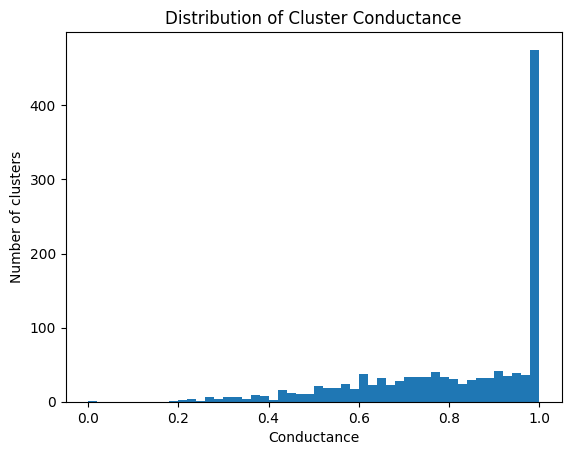

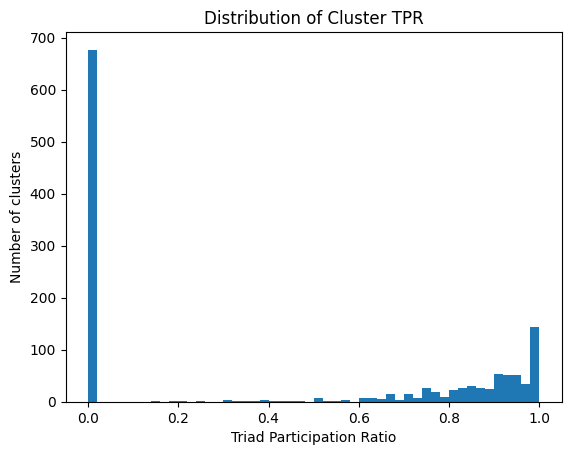

In [25]:
# Conductance distribution
plt.hist([x for x in cluster_eval["conductance"] if x is not None], bins=50)
plt.xlabel("Conductance")
plt.ylabel("Number of clusters")
plt.title("Distribution of Cluster Conductance")
plt.show()

# TPR distribution
plt.hist(cluster_eval["TPR"], bins=50)
plt.xlabel("Triad Participation Ratio")
plt.ylabel("Number of clusters")
plt.title("Distribution of Cluster TPR")
plt.show()


244


<Axes: >

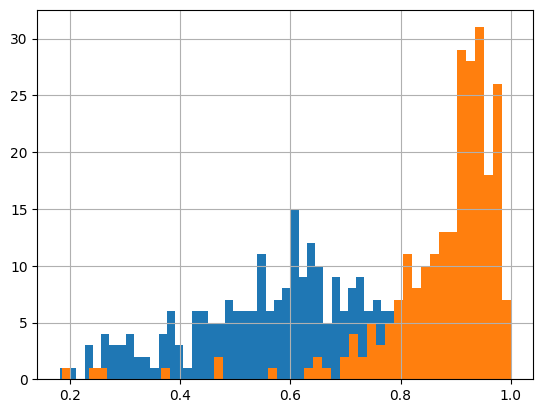

In [26]:
big_clusters = cluster_eval[cluster_eval["size"] >= 50]

print(len(big_clusters))

big_clusters["conductance"].hist(bins=50)
big_clusters["TPR"].hist(bins=50)


## Visualization

In [27]:
N_CLUSTERS = 20


Top 10 biggest clusters:
1. Cluster 5: 10318 nodes
2. Cluster 2: 5911 nodes
3. Cluster 1: 5204 nodes
4. Cluster 4: 4792 nodes
5. Cluster 10: 4259 nodes
6. Cluster 9: 3809 nodes
7. Cluster 21: 2513 nodes
8. Cluster 7: 2436 nodes
9. Cluster 3: 2317 nodes
10. Cluster 6: 2174 nodes

Top 10 smallest clusters:
1. Cluster 1128: 1 nodes
2. Cluster 790: 1 nodes
3. Cluster 1087: 1 nodes
4. Cluster 1091: 1 nodes
5. Cluster 1101: 1 nodes
6. Cluster 1163: 1 nodes
7. Cluster 1165: 1 nodes
8. Cluster 1182: 1 nodes
9. Cluster 279: 1 nodes
10. Cluster 1135: 1 nodes


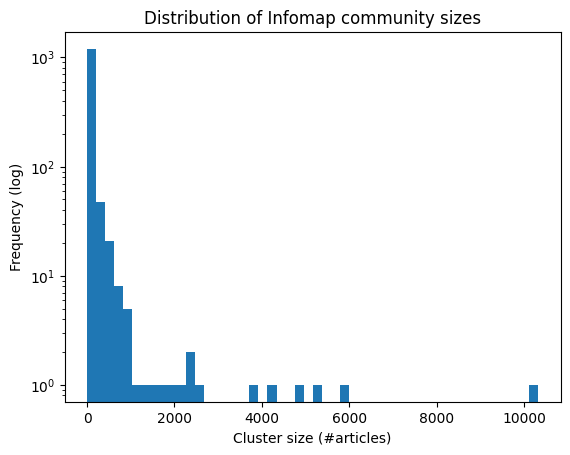

In [28]:
# Drop NaN and cast to int
clusters_clean = [
    int(c) for c in nodes_infomap["infomap_cluster"] 
    if not (isinstance(c, float) and math.isnan(c))
]

cluster_sizes = collections.Counter(clusters_clean)

def print_clusters(title, clusters):
    print(f"\n{title}")
    for i, (c, s) in enumerate(clusters, start=1):
        print(f"{i}. Cluster {c}: {s} nodes")

print_clusters("Top 10 biggest clusters:", cluster_sizes.most_common(10))
print_clusters("Top 10 smallest clusters:", sorted(cluster_sizes.items(), key=lambda x: x[1])[:10])


cluster_values = nodes_infomap["infomap_cluster"].value_counts()
plt.hist(cluster_values, bins=50, log=True)
plt.xlabel("Cluster size (#articles)")
plt.ylabel("Frequency (log)")
plt.title("Distribution of Infomap community sizes")
plt.show()

In [29]:
# Peek at titles in one cluster
cluster_id = 6
sample_titles = nodes_infomap[nodes_infomap["infomap_cluster"] == cluster_id]["d_properties_document_title"]
sample_titles

29                                            Lord's Prayer
41                                         History of Islam
84                      Live by the sword, die by the sword
97                                    Stations of the Cross
126                                    Parable of the Pearl
                                ...                        
107925                                     Circumambulation
107947                                  Albigensian Crusade
107951    Cathedral of Our Lady of the Rosary (Duluth, M...
107953                                Conversion to Judaism
108062           Prayer of Consecration to the Sacred Heart
Name: d_properties_document_title, Length: 2174, dtype: object

### TOP

In [30]:
def cluster_keywords(df, cluster_id, top_n=20):
    titles = df[df["infomap_cluster"] == cluster_id]["d_properties_document_title"].dropna().tolist()
    words = []
    for t in titles:
        tokens = re.findall(r"[A-Za-z]+", t)  # simple word split
        words.extend([w.lower() for w in tokens if len(w) > 3])
    return Counter(words).most_common(top_n)

for i in range(1, N_CLUSTERS+1):
    print(f"Cluster {i} keywords:\n", cluster_keywords(nodes_infomap, i))


Cluster 1 keywords:
 [('list', 654), ('countries', 168), ('history', 168), ('china', 100), ('european', 99), ('world', 91), ('economy', 83), ('republic', 82), ('national', 82), ('south', 63), ('flag', 62), ('states', 60), ('union', 59), ('empire', 57), ('government', 57), ('africa', 57), ('country', 56), ('geography', 55), ('cities', 54), ('europe', 54)]
Cluster 2 keywords:
 [('states', 1103), ('united', 1071), ('list', 557), ('state', 197), ('national', 177), ('carolina', 154), ('history', 151), ('american', 141), ('river', 139), ('north', 135), ('presidential', 115), ('south', 93), ('park', 88), ('house', 87), ('washington', 81), ('virginia', 79), ('election', 74), ('georgia', 72), ('federal', 70), ('party', 68)]
Cluster 3 keywords:
 [('computer', 91), ('software', 69), ('list', 61), ('data', 60), ('windows', 56), ('system', 54), ('programming', 53), ('computing', 52), ('microsoft', 49), ('history', 40), ('file', 40), ('protocol', 34), ('management', 32), ('network', 31), ('database'

It looks like you’ve got **20 keyword clusters** here — each one seems to represent a topic domain, probably extracted from a large text dataset (Wikipedia-like, based on the prevalence of "list" articles). I’ll break them down:

---

🌍 Geography, Countries, and Politics

* **Cluster 1** → General world geography, nations, political systems, flags, empires, Africa, Europe, China.
* **Cluster 2** → U.S.-specific: states, elections, presidential history, Washington, Virginia, Georgia, political parties.
* **Cluster 7** → United Kingdom & British Isles: London, England, Wales, Scotland, railways, rivers, monarchy.
* **Cluster 9** → India & South Asia: Indian states, institutes, Delhi, universities, government, Pakistan.
* **Cluster 12** → New York City: boroughs, subway, Manhattan, bridges, streets, parks.
* **Cluster 19** → Canada: provinces (Ontario, Quebec, Alberta), parties, elections, rivers, lakes.

---

💻 Science & Technology

* **Cluster 3** → Computing: programming, software, Microsoft, Java, networks, data, databases.
* **Cluster 4** → Medicine & Biology: diseases, proteins, cells, blood, human anatomy.
* **Cluster 8** → Chemistry: elements, acids, metals, isotopes, radiation, reactions.
* **Cluster 13** → Zoology & Evolution: animals, species, fish, birds, mammals, evolution.
* **Cluster 15** → Economics: trade, markets, price theory, taxation, international economics.
* **Cluster 17** → Linguistics: English, Spanish, Chinese, grammar, alphabets, surnames.
* **Cluster 18** → Environmental science: renewable energy, solar, nuclear, waste, agriculture, pollution.

---

🎭 Culture, Arts & Entertainment

* **Cluster 5** → Music: songs, love, albums, bands, best hits, heart, life.
* **Cluster 6** → Religion: Christianity, Catholicism, Bible, Islam, Jerusalem, saints.
* **Cluster 10** → Film & cinema: Academy Awards, actors, soundtracks, novels, American films.
* **Cluster 20** → Ancient Greece & mythology: gods, temples, Homer, Zeus, Athens.

---

📚 Social Sciences & History

* **Cluster 11** → Psychology & philosophy: social theory, ethics, cognition, intelligence.
* **Cluster 14** → Sports (American football): NFL, college football, Super Bowl, drafts, quarterbacks.
* **Cluster 16** → International relations: Cold War, U.S.–Soviet Union, communism, Vietnam, Iran, military history.

---

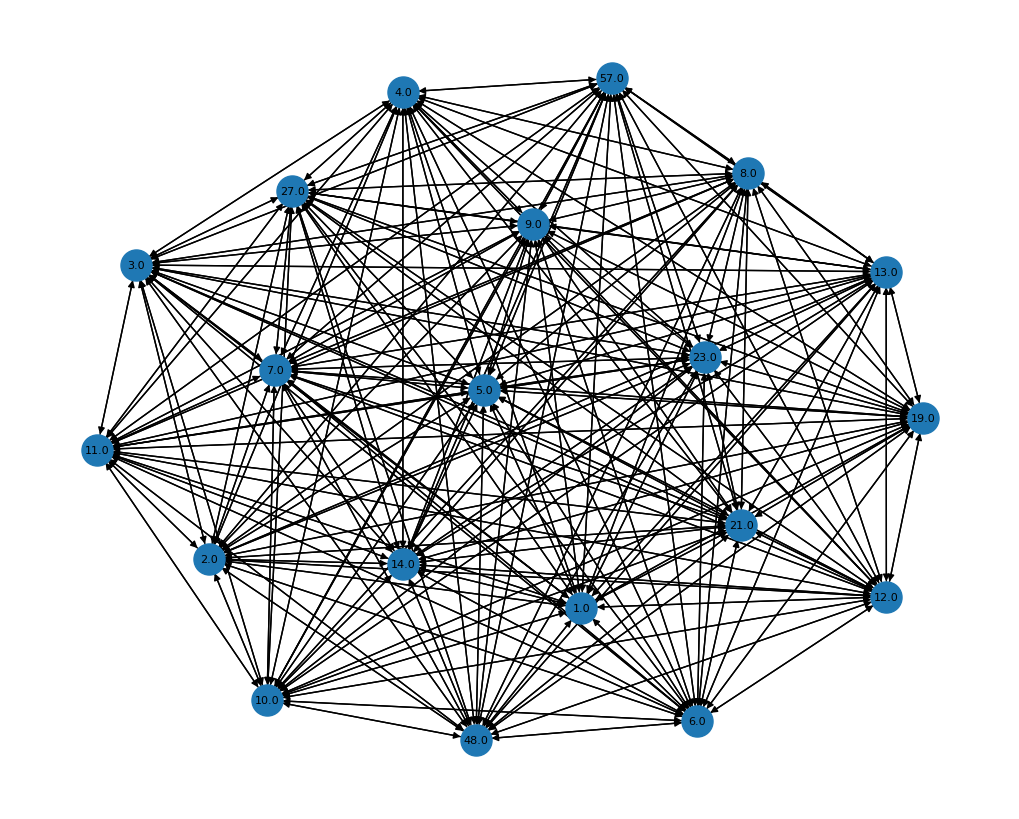

In [31]:
G = nx.DiGraph()
for _, row in nodes_infomap.iterrows():
    src_cluster = row["infomap_cluster"]
    for tgt in row["cites_ids"]:
        tgt_cluster = communities.get(tgt)  # lookup cluster for target
        if tgt_cluster is not None and src_cluster != tgt_cluster:
            G.add_edge(src_cluster, tgt_cluster)

# Select clusters
top_clusters = nodes_infomap["infomap_cluster"].value_counts().index[:N_CLUSTERS]

# Build subgraph of top clusters
subG = G.subgraph(top_clusters)

# Visualize
plt.figure(figsize=(10,8))
nx.draw(subG, with_labels=True, node_size=500, font_size=8)
plt.show()

### BOTTOM

In [32]:
# Count how many clusters have a given small size
for k in range(20):
    count = sum(1 for size in cluster_sizes.values() if size == k)
    print(f"Number of clusters with exactly {k} nodes: {count}")


Number of clusters with exactly 0 nodes: 0
Number of clusters with exactly 1 nodes: 450
Number of clusters with exactly 2 nodes: 148
Number of clusters with exactly 3 nodes: 68
Number of clusters with exactly 4 nodes: 59
Number of clusters with exactly 5 nodes: 28
Number of clusters with exactly 6 nodes: 23
Number of clusters with exactly 7 nodes: 11
Number of clusters with exactly 8 nodes: 16
Number of clusters with exactly 9 nodes: 15
Number of clusters with exactly 10 nodes: 18
Number of clusters with exactly 11 nodes: 8
Number of clusters with exactly 12 nodes: 12
Number of clusters with exactly 13 nodes: 10
Number of clusters with exactly 14 nodes: 11
Number of clusters with exactly 15 nodes: 10
Number of clusters with exactly 16 nodes: 5
Number of clusters with exactly 17 nodes: 12
Number of clusters with exactly 18 nodes: 12
Number of clusters with exactly 19 nodes: 5


In [33]:
def get_clusters_by_size(df, size, cols=None):
    """
    Extract all clusters of a given size (e.g. 1, 2, 3...).
    """
    df = df.dropna(subset=["infomap_cluster"]).copy()
    df["infomap_cluster"] = df["infomap_cluster"].astype(int)

    # Count cluster sizes
    cluster_sizes = Counter(df["infomap_cluster"])

    # Filter clusters of given size
    target_clusters = [c for c, s in cluster_sizes.items() if s == size]

    # Extract rows
    out_df = df[df["infomap_cluster"].isin(target_clusters)].copy()

    # Select columns if provided
    if cols is not None:
        out_df = out_df[cols]

    # Sort by cluster so nodes appear grouped
    out_df = out_df.sort_values(by="infomap_cluster")

    return out_df

cols = ["id", "d_properties_document_title", "cites_ids", "cites_len", "infomap_cluster"]

singleton_df = get_clusters_by_size(nodes_infomap, size=1, cols=cols)
pair_df      = get_clusters_by_size(nodes_infomap, size=2, cols=cols)

KeyError: "['cites_len'] not in index"

In [ ]:
singleton_df

,id,d_properties_document_title,cites_ids,cites_len,infomap_cluster
9145,10786,Encyclopedia Americana,[],0,279
72027,73668,List of megaprojects,"[65325, 6450, 42564, 18341, 25828, 29495, 3309...",310,573
105682,107323,Elon Musk,"[67332, 84641, 20515, 67836, 25737, 12864, 867...",159,582
89254,90895,History of libraries,"[74, 58236, 30755, 22423, 40374, 80297, 64934,...",92,589
103138,104779,Eternal flame,"[101015, 61203, 93675, 49023, 42077, 46085, 39...",141,619
...,...,...,...,...,...
76123,77764,Percival Gull,"[74197, 64590, 71369, 23474, 28583, 37675, 544...",15,1290
75986,77627,List of horse racing venues,"[44872, 29956, 12123, 58447, 41076, 37167, 287...",119,1291
75952,77593,Will no one rid me of this turbulent priest?,"[48803, 18130, 58806, 51593, 30696, 68735, 759...",13,1292
75562,77203,History of Stockholm,"[5907, 26310, 69044, 30928, 43863, 17770, 2748...",8,1293


In [ ]:
pair_df

,id,d_properties_document_title,cites_ids,cites_len,infomap_cluster
30225,31866,IronPython,"[16136, 20835, 32747]",3,390
31106,32747,Manifest (CLI),[31866],1,390
29569,31210,2000s (decade),"[20125, 4846, 23244, 5402, 7720, 10814, 605, 6...",654,429
91253,92894,David Icke,"[56753, 52283, 51593, 89457, 22775, 258, 26434...",156,429
13514,15155,Institut de Physique du Globe de Paris,[15185],1,453
...,...,...,...,...,...
127,166,Mom and Dad (2017 film),"[57062, 29925, 51827, 19755, 62473]",5,888
104777,106418,Gangstar Vegas,"[485, 50592, 50839, 103164, 7115, 41475, 11718...",27,889
42641,44282,Asphalt 9: Legends,"[41475, 7115, 3482, 13975, 22927, 11240, 10497...",19,889
82390,84031,Manitou Incline,"[47065, 50805, 26010, 84523, 35682, 64679, 181...",10,890


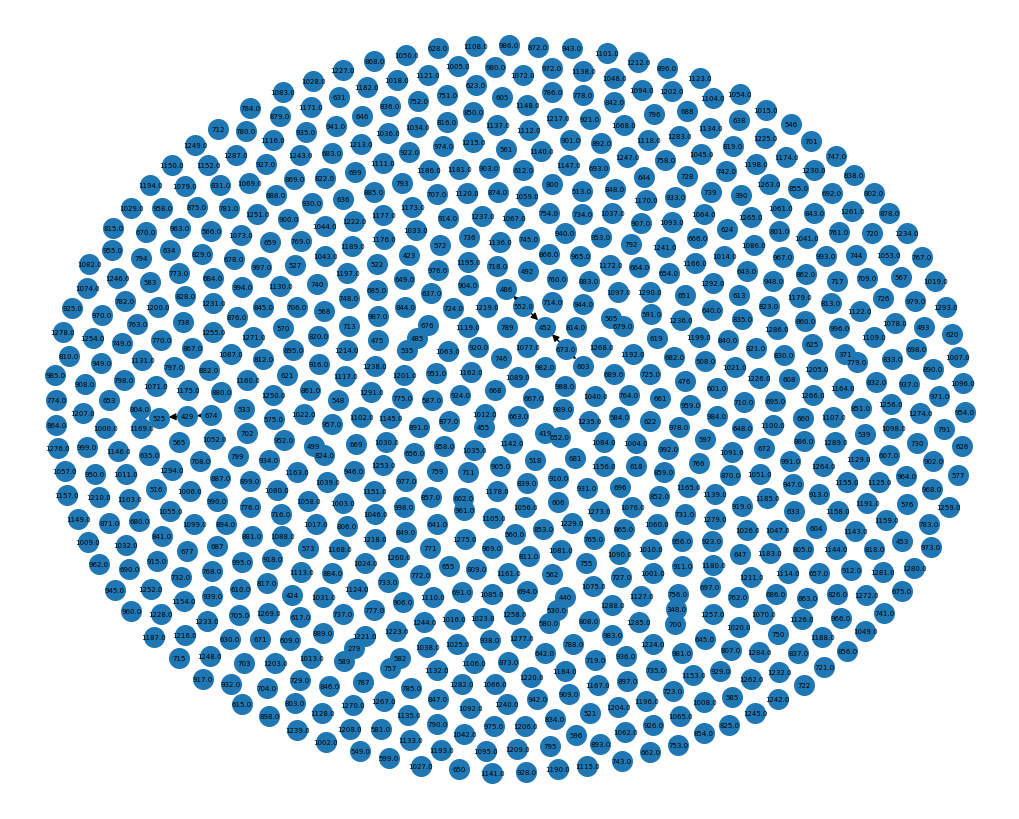

In [ ]:
N_SMALL = 450 + 296

# Select clusters
small_clusters  = nodes_infomap["infomap_cluster"].value_counts().index[-N_SMALL:]

# Build subgraph of top clusters
subG = G.subgraph(small_clusters)

# Visualize
plt.figure(figsize=(10,8))
nx.draw(subG, with_labels=True, node_size=200, font_size=5)
plt.show()